In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits

class ObservationData:
    """
    Class for managing a directory containing observational data. Wraps a pd dataframe storing all the data's relevant headers.
    """    
    
    def __init__(self, path: str):    
        self.directory_path = path
        self.refresh_dir()
    
    def refresh_dir(self):
        directory = []
        for f in os.listdir(self.directory_path):
            if not (f.lower().endswith('.fits') or f.lower().endswith('.fit')):
                continue  # skip non-FITS files
            try:
                with fits.open(os.path.join(self.directory_path, f)) as hdul:
                    header = hdul[0].header

                    row = {"FILENAME" : os.path.basename(f),
                    "OBJECT" : header.get("OBJECT", None),
                    "FILTER" : header.get("FILTER", None),
                    "IMAGETYP" : header.get("IMAGETYP", None),
                    "DATE-OBS" : header.get("DATE-OBS", None),
                    "EXP-TIME" : header.get("EXP-TIME", None),
                    "JD" : header.get("JD", None)}
                    directory.append(row)
            except Exception as e:
                print(f"Warning: Skipped file {f}: {e}")
        self.directory_frame = pd.DataFrame(directory)
    
    def add_file(self, f):
        with fits.open(os.path.join(self.directory_path, f)) as hdul:
                header = hdul[0].header

                row = {"FILENAME" : os.path.basename(f),
                "OBJECT" : header.get("OBJECT", None),
                "FILTER" : header.get("FILTER", None),
                "IMAGETYP" : header.get("IMAGETYP", None),
                "DATE-OBS" : header.get("DATE-OBS", None),
                "EXP-TIME" : header.get("EXP-TIME", None),
                "JD" : header.get("JD", None)}
                
        self.directory_frame = pd.concat([self.directory_frame, pd.DataFrame([row])], ignore_index=True)
            
    
    def load_data(self, expression) -> np.ndarray:
        files = self.filter(expression, replace=False)
        data = np.array([fits.getdata(os.path.join(self.directory_path, f)) for f in files["FILENAME"]])
        return np.dstack(data)
    
    @staticmethod
    def plot_gray_scale(data: np.ndarray | str, title: str) -> None:
        if isinstance(data, str):
            data = fits.getdata(data)
            
        fig, ax = plt.subplots(figsize=(10,8))
        img_display = ax.imshow(data, cmap='gray', vmin=np.percentile(data, 5), vmax=np.percentile(data, 95))
        cbar = fig.colorbar(img_display, ax=ax)

        ax.set_title(title, pad=20)
        ax.grid(False)
        plt.tight_layout()
        plt.show()
        
    def filter(self, expression: str, replace: bool = False) -> pd.DataFrame | None:
        if replace:
            self.directory_frame = self.directory_frame.query(expression)
        else:
            return self.directory_frame.query(expression)

    def save_csv(self, file_name: str) -> None:
        self.directory_frame.to_csv(file_name)
    
    def load_csv(self, file_name: str) -> None:
        self.directory_frame = pd.read_csv(file_name)
        

class Corrector:
    def __init__(self, master_bias, flat_dict):
        self.bias = master_bias
        self.flat = flat_dict
    

    def correct(self, data: np.ndarray, fil: str):
        return (data - self.bias) / self.flat[fil]
        


In [14]:
#from ObservationData import ObservationData, Corrector
from astropy.time import Time
from astropy.io import fits
import astroalign as aa
from tqdm import tqdm
import os


data_manager = ObservationData("/net/virgo01/data/users/kjkarbowski/2025-04-30/")

end_jd = Time("2025-04-30 23:30").jd
data_manager.directory_frame.sort_values(by="JD", inplace=True)
print(data_manager.directory_frame)
data_manager.save_csv("raw_files.csv")
data_manager.filter(f"JD <= {end_jd}", replace=True)
data_manager.save_csv("file_data.csv")


                            FILENAME       OBJECT   FILTER     IMAGETYP  \
317                 master_bias.fits  LDST_250430     None  MASTER_BIAS   
253        LDST_250430-0001_Bias.fit  LDST_250430     None         BIAS   
212        LDST_250430-0002_Bias.fit  LDST_250430     None         BIAS   
73         LDST_250430-0003_Bias.fit  LDST_250430     None         BIAS   
0          LDST_250430-0004_Bias.fit  LDST_250430     None         BIAS   
..                               ...          ...      ...          ...   
344  LDST_250430-0003_Halphaflat.fit  LDST_250430  H_alpha         FLAT   
365  LDST_250430-0004_Halphaflat.fit  LDST_250430  H_alpha         FLAT   
89   LDST_250430-0005_Halphaflat.fit  LDST_250430  H_alpha         FLAT   
191        LDST_250430-0015_dark.fit  LDST_250430    ND1.2        LIGHT   
234        LDST_250430-0016_dark.fit  LDST_250430    ND1.2        LIGHT   

                   DATE-OBS EXP-TIME            JD  
317  2025-04-30T18:22:10.41     None  2.460796

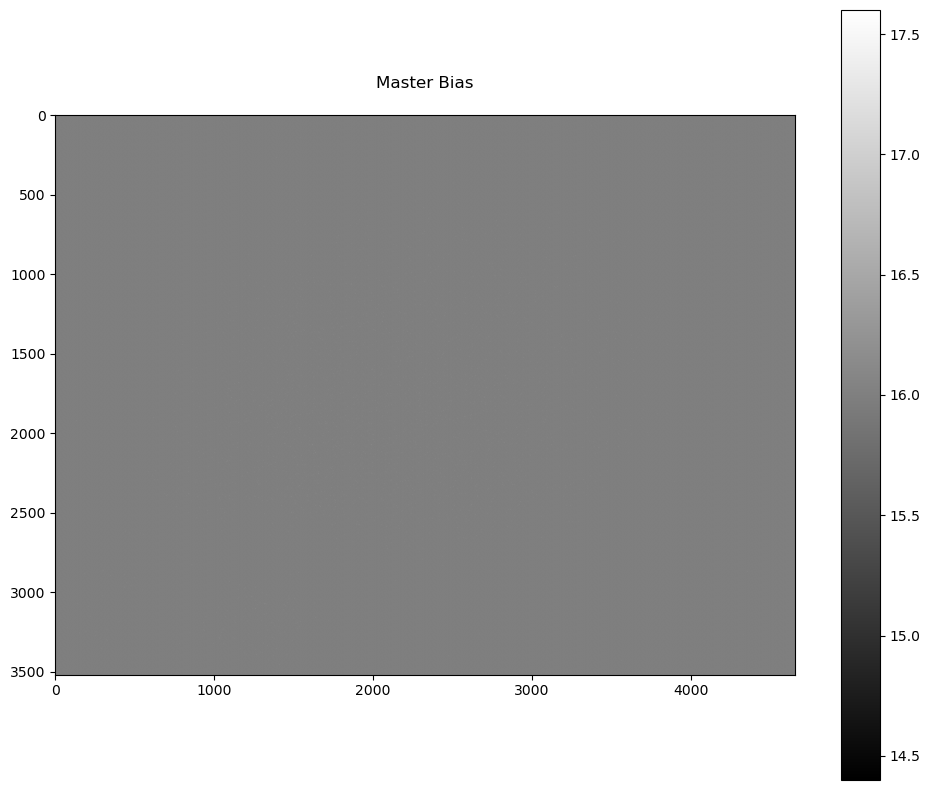

In [15]:
# Compute Master Bias
import numpy as np

bias_files = data_manager.filter(f"IMAGETYP == 'BIAS'", replace=False)["FILENAME"].tolist()

bias_data = data_manager.load_data(f"IMAGETYP == 'BIAS'")
master_bias = np.median(bias_data, axis=-1)

header = fits.getheader(os.path.join(data_manager.directory_path, bias_files[0]))
header['IMAGETYP'] = 'MASTER_BIAS'
header['NFRAMES'] = len(bias_data)
header['COMBINED'] = 'MEDIAN'
header['COMMENT'] = 'Master bias frame created from raw bias exposures'

fits.writeto(os.path.join(data_manager.directory_path, 'master_bias.fits'), master_bias, header, overwrite=True)
data_manager.add_file('master_bias.fits')

data_manager.plot_gray_scale(master_bias, "Master Bias")


{'Lum', 'G*', 'R*', None, 'H_alpha', 'ND1.2', 'B*'}


  0%|          | 0/7 [00:00<?, ?it/s]

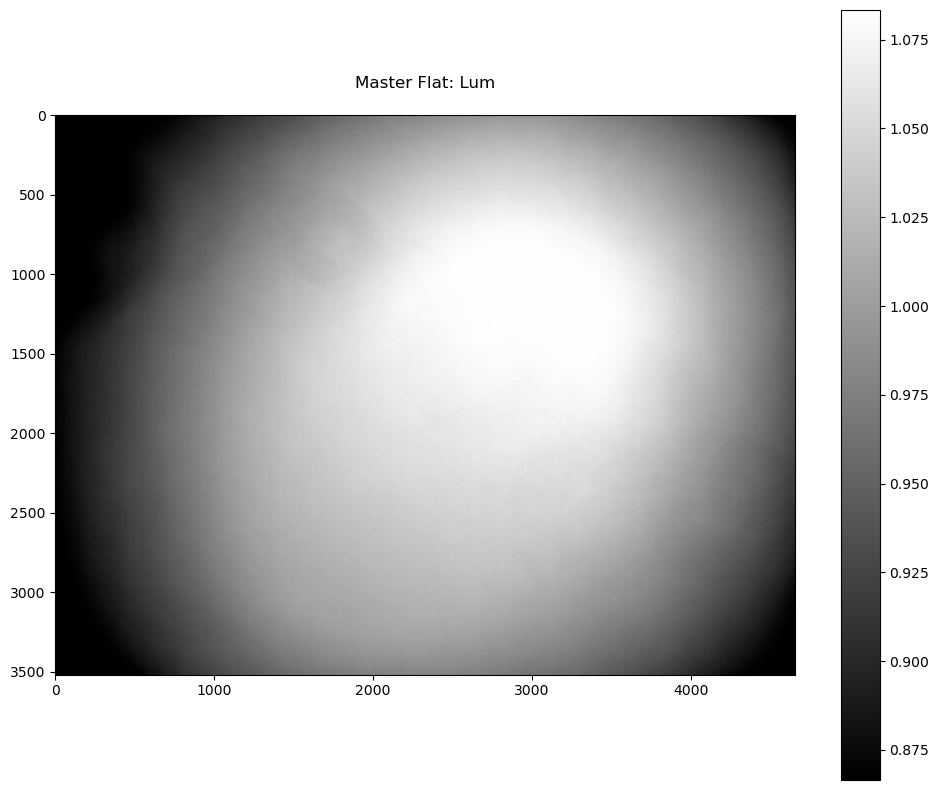

 14%|█▍        | 1/7 [00:06<00:40,  6.78s/it]

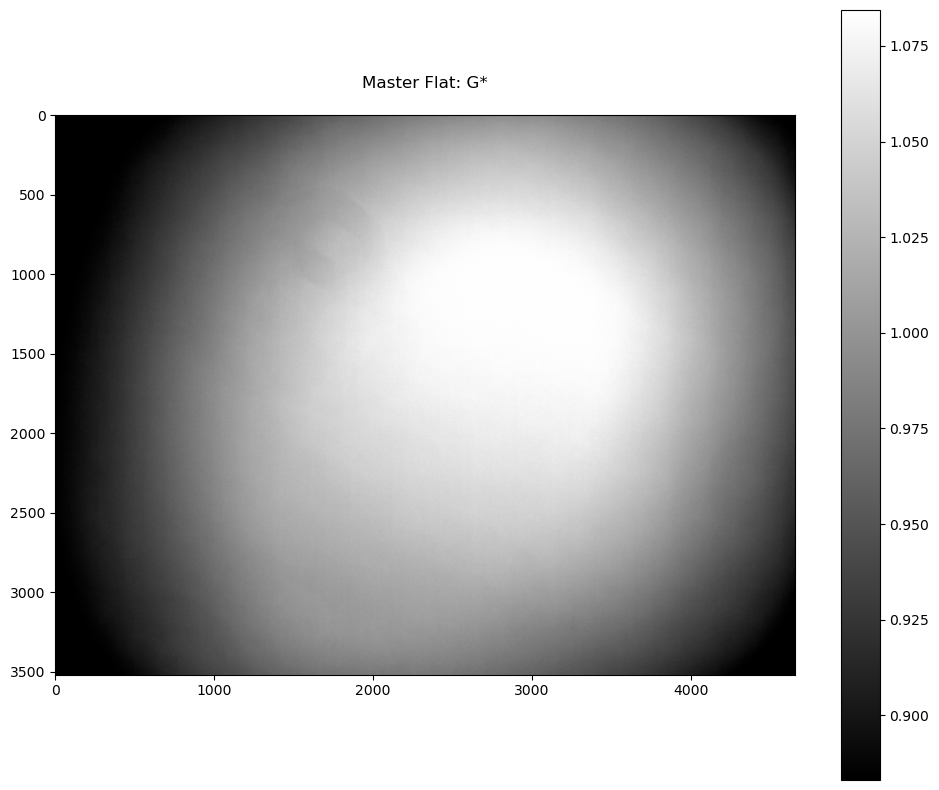

 29%|██▊       | 2/7 [00:12<00:31,  6.24s/it]

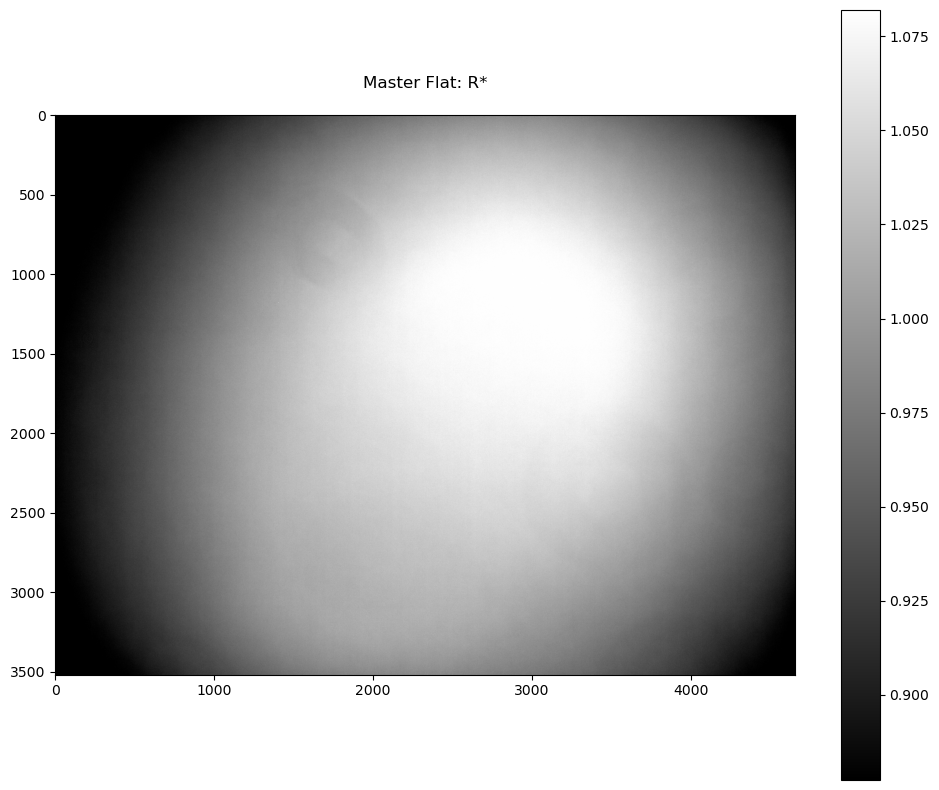

 43%|████▎     | 3/7 [00:18<00:24,  6.24s/it]

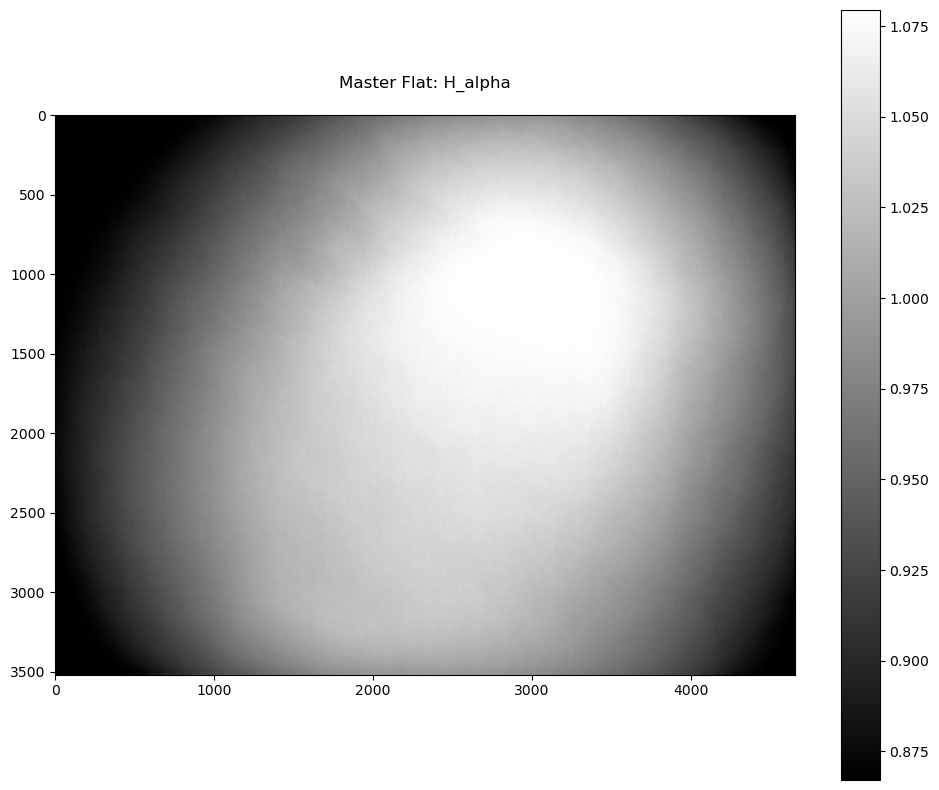

 71%|███████▏  | 5/7 [00:25<00:09,  4.54s/it]

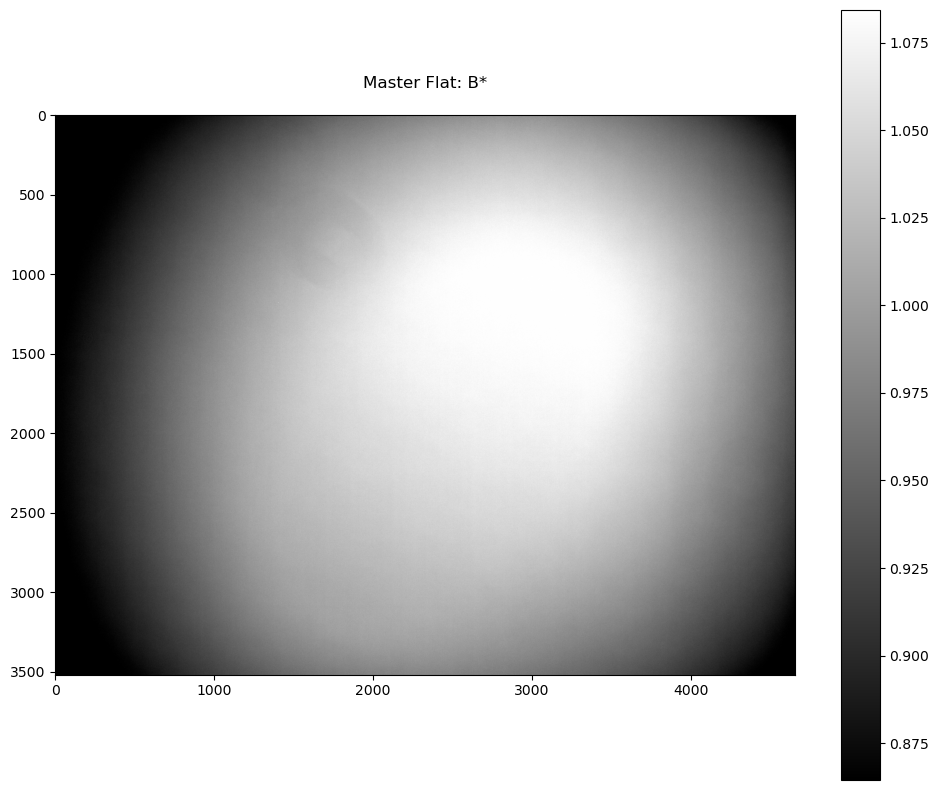

100%|██████████| 7/7 [00:34<00:00,  4.93s/it]


In [16]:
# Compute Master FLATS
import numpy as np

flat_files = data_manager.filter("IMAGETYP == 'FLAT'", replace=False)
master_bias = fits.getdata(os.path.join(data_manager.directory_path, 'master_bias.fits'))


filters = set(data_manager.directory_frame["FILTER"])
print(filters)
flat_dict = {}

header = fits.getheader(os.path.join(data_manager.directory_path, flat_files['FILENAME'].tolist()[0]))
header['IMAGETYP'] = 'MASTER_BIAS'

header['COMBINED'] = 'MEDIAN'
header['COMMENT'] = 'Master bias frame created from normalized flat exposures'

for fil in tqdm(filters):
    if fil is None or fil == "ND1.2":
        continue
    
  
    
    flat_data = data_manager.load_data(f"IMAGETYP == 'FLAT' & FILTER == '{fil}'")
    normalized_data = (flat_data - master_bias[..., np.newaxis]) / np.median(flat_data, axis=(0,1))  
        
    flat_dict[fil] = np.median(normalized_data, axis=-1)

    header['NFRAMES'] = len(flat_data)
    header['FILTER'] = fil 
    
    data_manager.plot_gray_scale(flat_dict[fil], f"Master Flat: {fil}")
    
    fits.writeto(os.path.join(data_manager.directory_path, f'master_flat_{fil}.fits'), master_bias, header, overwrite=True)
    data_manager.add_file(f'master_flat_{fil}.fits')



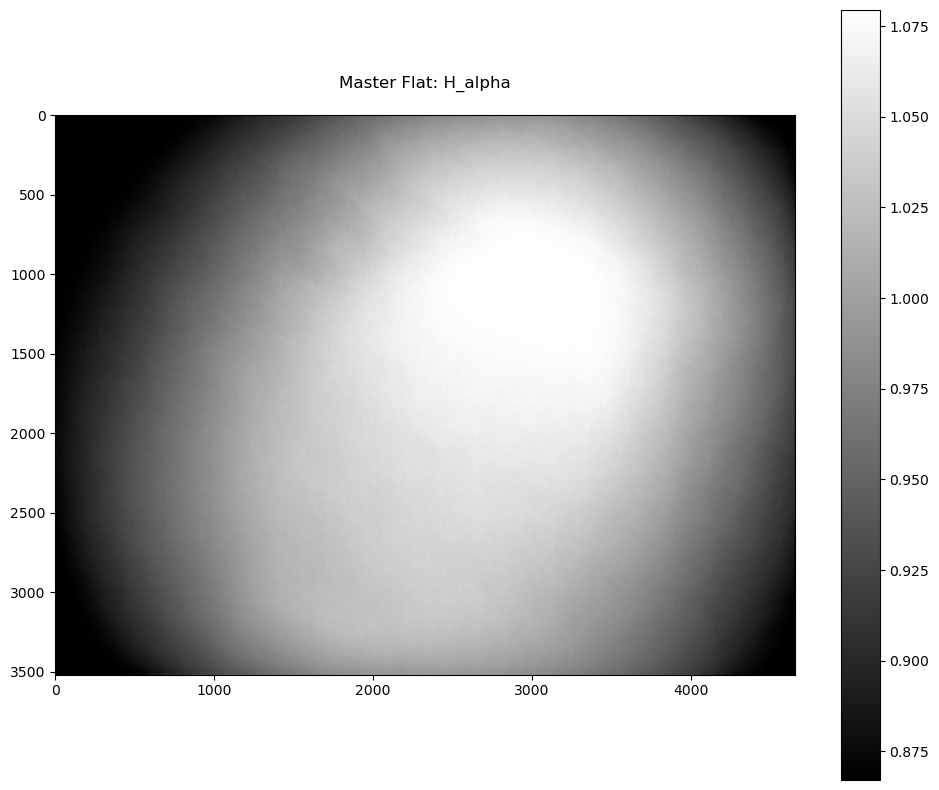

In [21]:

# === DEBUG 1: Plot the H_alpha flat ===
if 'H_alpha' in flat_dict:
    ObservationData.plot_gray_scale(flat_dict['H_alpha'], "Master Flat: H_alpha")
else:
    print("H_alpha not in flat_dict. Available filters:", flat_dict.keys())

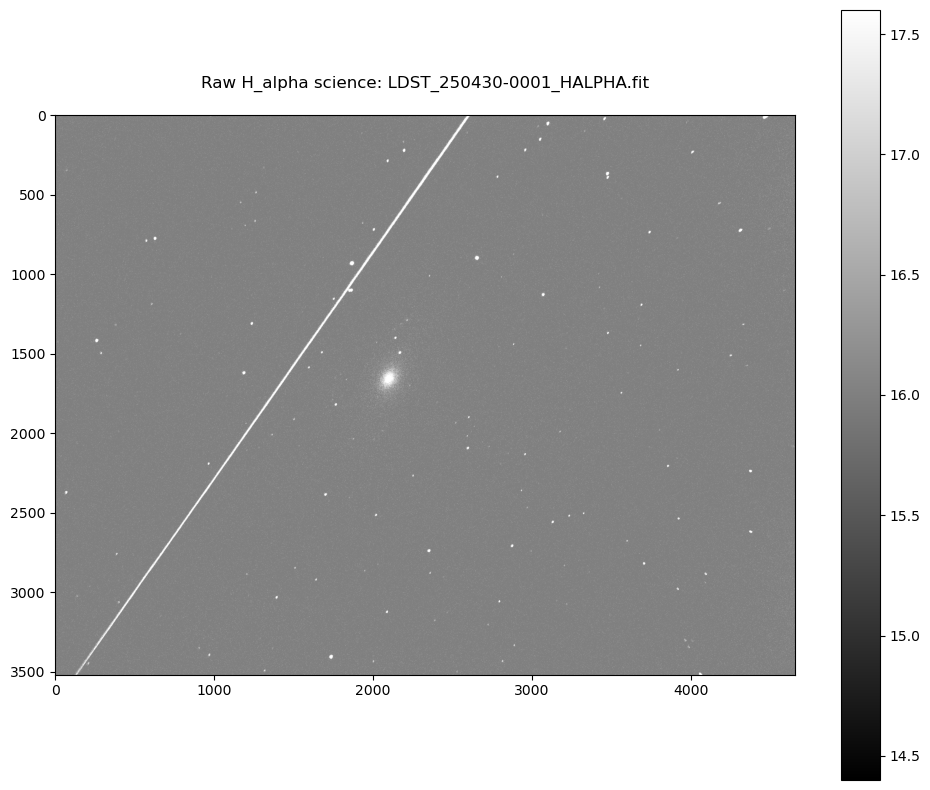

Raw H_alpha stats: min = 16 max = 65072 mean = 17.04170376444861 std = 45.94562766400715


In [22]:
# === DEBUG 2: Plot a raw H_alpha science frame ===
raw_halpha_df = data_manager.filter("IMAGETYP == 'LIGHT' & FILTER == 'H_alpha'", replace=False)
if len(raw_halpha_df) > 0:
    raw_halpha_file = raw_halpha_df.iloc[0]['FILENAME']
    raw_halpha_data = fits.getdata(os.path.join(data_manager.directory_path, raw_halpha_file))
    ObservationData.plot_gray_scale(raw_halpha_data, f"Raw H_alpha science: {raw_halpha_file}")
    print("Raw H_alpha stats: min =", np.min(raw_halpha_data), 
          "max =", np.max(raw_halpha_data), 
          "mean =", np.mean(raw_halpha_data), 
          "std =", np.std(raw_halpha_data))
else:
    print("No raw H_alpha science images found!")


In [17]:
import matplotlib.pyplot as plt

data_corrector = Corrector(master_bias, flat_dict)

img_files = data_manager.filter("IMAGETYP == 'LIGHT' & FILTER != 'ND1.2' & FILTER != 'None'")

for idx, row in tqdm(img_files.iterrows()):
    fp = row["FILENAME"]
    name = fp.split('_')[-1][:-4]
    
    data = fits.getdata(os.path.join(data_manager.directory_path, fp))
    
    corrected = data_corrector.correct(data, row["FILTER"])
    
    
    header = fits.getheader(os.path.join(data_manager.directory_path, fp))
    header['COMMENT'] = 'Reduced frame created from master_bias and master_flat'
    header['IMAGETYP'] = 'REDUCED'
    header['OBJECT'] = "M82" if len(name) < 4 else "STARFIELD"
    fits.writeto(os.path.join(data_manager.directory_path, f'reduced_{name}_{idx}.fits'), corrected, header, overwrite=True)
    data_manager.add_file(f'reduced_{name}_{idx}.fits')

128it [00:50,  2.56it/s]


Inspecting file with the brightest outlier: /net/virgo01/data/users/kjkarbowski/2025-04-30/reduced_HALPHA_53.fits


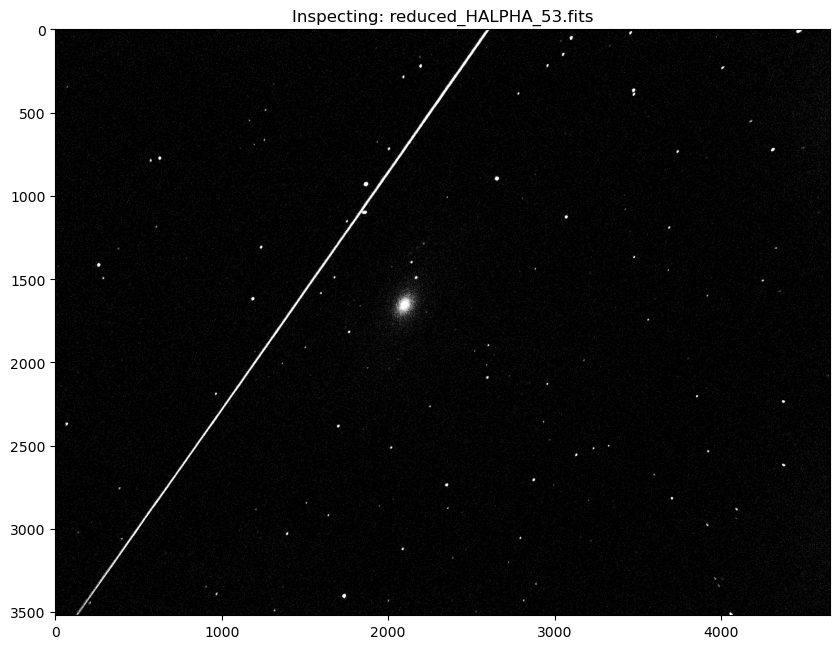

177116 pixels masked of 16389120 (1.0807%)


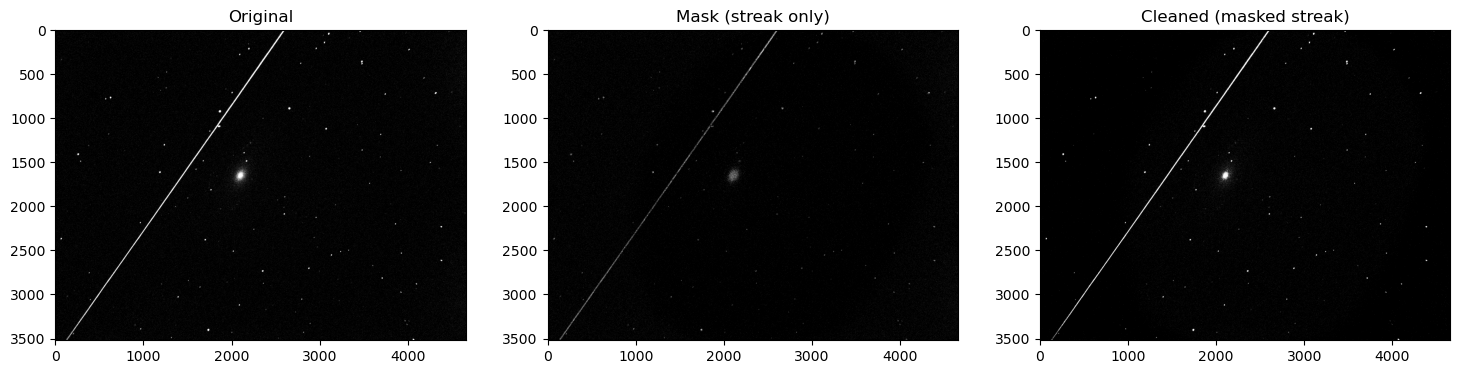

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from astroscrappy import detect_cosmics
from astropy.io import fits
import os

reduced_files = data_manager.filter("IMAGETYP == 'REDUCED' & FILTER == 'H_alpha'", replace=False)

if reduced_files.empty:
    print("No reduced H_alpha images found!")
else:
    best_file = None
    max_brightness = -np.inf
    for _, row in reduced_files.iterrows():
        fname = row['FILENAME']
        path = os.path.join(data_manager.directory_path, fname)
        data = fits.getdata(path)
        bright = np.percentile(data, 99.99)
        if bright > max_brightness:
            max_brightness = bright
            best_file = path

    print(f"Inspecting file with the brightest outlier: {best_file}")
    data = fits.getdata(best_file)

    plt.figure(figsize=(10,8))
    plt.title(f"Inspecting: {os.path.basename(best_file)}")
    plt.imshow(data, cmap='gray', vmin=np.percentile(data, 5), vmax=np.percentile(data, 99))
    plt.show()

    mask, clean = detect_cosmics(
        data,
        gain=1.4,
        readnoise=15.2,
        sigclip=1.5,      # Lower catches more streaks
        objlim=5.0,     # Optional: lower means "mask fainter objects"
        satlevel=np.max(data)*4   # Prevents stars being flagged as saturated
    )

    print(f"{np.count_nonzero(mask)} pixels masked of {data.size} ({100 * np.count_nonzero(mask) / data.size:.4f}%)")

    fig, axs = plt.subplots(1, 3, figsize=(18,6))
    axs[0].imshow(data, cmap='gray', vmin=np.percentile(data, 5), vmax=np.percentile(data, 99)); axs[0].set_title('Original')
    axs[1].imshow(mask, cmap='gray'); axs[1].set_title('Mask (streak only)')
    axs[2].imshow(clean, cmap='gray', vmin=np.percentile(clean, 5), vmax=np.percentile(clean, 99)); axs[2].set_title('Cleaned (masked streak)')
    plt.show()


Raw data stats: min -80.98191214470285 max 64638.40531561462 mean 1.0370782564339087
Initial mask pixels: 722
Dilated mask pixels: 12506
Mask covers 0.08% of the image.
Cleaned data stats: min -80.98191214470285 max 997.3561811505507 mean 0.88261716003681


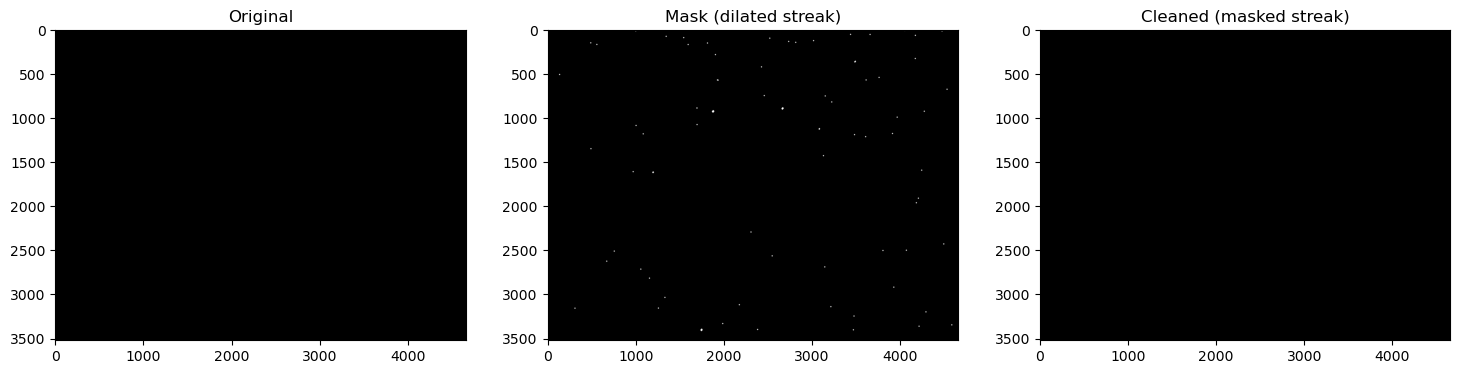

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from scipy.ndimage import binary_dilation

file_path = "/net/virgo01/data/users/kjkarbowski/2025-04-30/reduced_HALPHA_53.fits"
data = fits.getdata(file_path)

streak_threshold = 1000
mask_streak = data > streak_threshold

mask_dilated = binary_dilation(mask_streak, iterations=8)

data_clean = np.array(data, copy=True)
data_clean[mask_dilated] = np.median(data[~mask_dilated])

mean, median, std = sigma_clipped_stats(data, sigma=3.0)
vmin = median - 2*std
vmax = median + 8*std

print(f"Raw data stats: min {np.min(data)} max {np.max(data)} mean {np.mean(data)}")
print(f"Initial mask pixels: {np.count_nonzero(mask_streak)}")
print(f"Dilated mask pixels: {np.count_nonzero(mask_dilated)}")
print(f"Mask covers {100*np.count_nonzero(mask_dilated)/data.size:.2f}% of the image.")
print(f"Cleaned data stats: min {np.min(data_clean)} max {np.max(data_clean)} mean {np.mean(data_clean)}")

fig, axs = plt.subplots(1, 3, figsize=(18,6))
axs[0].imshow(data, cmap='gray', vmin=vmin, vmax=vmax)
axs[0].set_title('Original')
axs[1].imshow(mask_dilated.astype(float), cmap='gray', vmin=0, vmax=1)
axs[1].set_title('Mask (dilated streak)')
axs[2].imshow(data_clean, cmap='gray', vmin=vmin, vmax=vmax)
axs[2].set_title('Cleaned (masked streak)')
plt.show()


In [6]:
from itertools import combinations


registered_files = data_manager.filter("IMAGETYP == 'REGISTERED'")
file = registered_files['FILENAME'].tolist()[0]
header = fits.getheader(os.path.join(data_manager.directory_path, file))
filters = set(registered_files["FILTER"])
objects = set(registered_files["OBJECT"])
pairs = combinations(filters, objects)

for fil, obj in pairs:
    data = data_manager.load_data(f"FILTER == '{fil} & '{obj}'")
    final = data.median(axis=-1)
    
    header['COMMENT'] = 'Finalized frame created from registered images'
    header['IMAGETYP'] = 'FINAL'
    fits.writeto(os.path.join(data_manager.directory_path, f'final_{obj}_{fil}.fits'), corrected, header, overwrite=True)
    data_manager.add_file(f'final_{obj}_{fil}.fits')
    
    

FileNotFoundError: [Errno 2] No such file or directory: '/net/virgo01/data/users/tboersma/2025-04-30/reduced__53.fits'